In [113]:
import numpy as np 
import pandas as pd 
import ccxt 
from tqdm.auto import tqdm 
from datetime import timedelta
import pandas_ta as ta
import seaborn as sns
from xgboost import XGBClassifier # modeling
from sklearn.utils.class_weight import compute_class_weight

In [4]:
df = pd.read_csv("minute_data.csv") 

In [34]:
open_val = df["open"].values 
high_val = df["high"].values 
low_val = df["low"].values 
close_val = df["close"].values  
volume_val = df["volume"].values 


open_values = [] 
high_values = [] 
low_values = [] 
close_values = [] 
volume_values = [] 
datetime_values = [] 

for i in tqdm(range(df.shape[0]), position=0, leave=True): 
    chart_df = df.iloc[i:i+180] 
    open_values.append(chart_df["open"].values[0]) 
    low_values.append(np.min(chart_df["low"].values)) 
    high_values.append(np.max(chart_df["high"].values)) 
    close_values.append(chart_df["close"].values[-1]) 
    volume_values.append(np.sum(chart_df["volume"].values)) 
    datetime_values.append(chart_df["datetime"].values[0]) 
    
temp_df = pd.DataFrame(list(zip(open_values, high_values, low_values, close_values, volume_values, datetime_values)), 
                  columns=["open", "high", "low", "close", "volume", "datetime"]) 

temp_df

  0%|          | 0/2705171 [00:00<?, ?it/s]

,open,high,low,close,volume,datetime
0,4261.48,4345.45,4261.32,4324.35,77.645616,2017-08-17 04:00:00
1,4261.48,4345.45,4261.32,4324.35,75.870433,2017-08-17 04:01:00
2,4280.56,4345.45,4261.32,4324.35,75.870433,2017-08-17 04:02:00
3,4261.48,4345.45,4261.32,4324.35,75.609359,2017-08-17 04:03:00
4,4261.48,4345.45,4261.32,4324.35,75.597351,2017-08-17 04:04:00
...,...,...,...,...,...,...
2705166,19349.76,19375.00,19340.11,19368.16,1113.713500,2022-10-14 16:38:00
2705167,19352.52,19375.00,19340.11,19368.16,805.680590,2022-10-14 16:39:00
2705168,19348.91,19375.00,19340.11,19368.16,631.715140,2022-10-14 16:40:00
2705169,19353.45,19375.00,19345.27,19368.16,426.444730,2022-10-14 16:41:00


In [36]:
targets_arr = []
threshold = 0.007 # 0.7% 
for i in tqdm(range(temp_df.shape[0])):
    dt = pd.to_datetime(temp_df["datetime"].values[i])  
    target_dt = dt + timedelta(hours=4) 
    if target_dt in datetime_table.keys(): 
        info = datetime_table[target_dt] 
        high_val = info["high"]  
        low_val = info["low"]
        close = temp_df["close"].values[i] 
        high_volatility = (high_val - close) / close 
        low_volatility = (low_val - close) / close 
        if high_volatility >= threshold: 
            targets_arr.append(0) 
        elif low_volatility <= -threshold: 
            targets_arr.append(1) 
        else: 
            targets_arr.append(2) 
        

  0%|          | 0/2705171 [00:00<?, ?it/s]

In [37]:
while len(targets_arr) < temp_df.shape[0]: 
    targets_arr.append(None) 

In [38]:
temp_df["Targets"] = targets_arr 

In [39]:
temp_df

,open,high,low,close,volume,datetime,Targets
0,4261.48,4345.45,4261.32,4324.35,77.645616,2017-08-17 04:00:00,0.0
1,4261.48,4345.45,4261.32,4324.35,75.870433,2017-08-17 04:01:00,0.0
2,4280.56,4345.45,4261.32,4324.35,75.870433,2017-08-17 04:02:00,0.0
3,4261.48,4345.45,4261.32,4324.35,75.609359,2017-08-17 04:03:00,0.0
4,4261.48,4345.45,4261.32,4324.35,75.597351,2017-08-17 04:04:00,0.0
...,...,...,...,...,...,...,...
2705166,19349.76,19375.00,19340.11,19368.16,1113.713500,2022-10-14 16:38:00,NaN
2705167,19352.52,19375.00,19340.11,19368.16,805.680590,2022-10-14 16:39:00,NaN
2705168,19348.91,19375.00,19340.11,19368.16,631.715140,2022-10-14 16:40:00,NaN
2705169,19353.45,19375.00,19345.27,19368.16,426.444730,2022-10-14 16:41:00,NaN


In [91]:
datetime_table = {}  

for i in tqdm(range(temp_df.shape[0])): 
    dt = pd.to_datetime(temp_df["datetime"].values[i]) 
    datetime_table[dt] = temp_df.iloc[i] 

  0%|          | 0/2700006 [00:00<?, ?it/s]

In [ ]:
import pickle

with open('datetime_table.pickle', 'wb') as handle:
    pickle.dump(datetime_table, handle)

with open('datetime_table.pickle', 'rb') as handle:
    datetime_table = pickle.load(handle)

In [61]:
temp_df.dropna(inplace=True)

In [62]:
temp_df.to_csv("minute_with_targets.csv",index=False)

<AxesSubplot:xlabel='Targets', ylabel='count'>

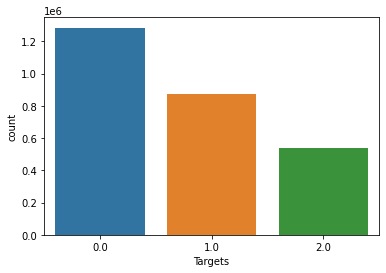

In [63]:
sns.countplot(data=temp_df, x="Targets")

In [104]:
def process_chart_data(chart_df):
    chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)
    ### addition of chart features ### 
    chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
    chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
    chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
    chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
    chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
    chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
    chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
    chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
    chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
    chart_df["linreg"] = chart_df.ta.linreg(lookahead=False) 
    chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
    chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"] 

    ### addition of recent differenced features ### 
    for l in range(1, 12): 
        for col in ["high", "low", "volume"]:
            val = chart_df[col].values 
            val_ret = [None for _ in range(l)]
            for i in range(l, len(val)):
                if val[i-l] == 0: 
                    ret = 1 
                else:
                    ret = val[i] / val[i-l]  
                val_ret.append(ret) 
            chart_df["{}_change_{}".format(col, l)] = val_ret

    ### drop unnecessary columns ### 
    chart_df.drop(columns={"open","high","low","close","volume","linreg","hwma","datetime"}, inplace=True) 
    chart_df.dropna(inplace=True)
    return chart_df

In [107]:
latest_date = pd.to_datetime(temp_df["datetime"].values[-1]) 

full_dfs = [] 

for i in tqdm(range(temp_df.shape[0]), position=0, leave=True):
    cur_chart_df = temp_df.iloc[i,:]   
    dt = cur_chart_df["datetime"]
    dt = pd.to_datetime(dt) 
    df_list = [cur_chart_df] 
    while dt <= latest_date: 
        dt = dt + timedelta(hours=4) 
        if dt in datetime_table.keys(): 
            df_list.append(datetime_table[dt])
    cur_df = pd.concat(df_list, axis=1).T 
    cur_df = process_chart_data(cur_df) 
    full_dfs.append(cur_df) 
    if i==100: 
        break
    

  0%|          | 0/2700006 [00:00<?, ?it/s]

In [121]:
train_size = int(full_dfs[0].shape[0] * 0.8) 
val_size = int(full_dfs[0].shape[0] * 0.1) 

train_dfs, val_dfs, test_dfs = [], [], [] 
for i in tqdm(range(len(full_dfs)), position=0, leave=True): 
    full_df = full_dfs[i] 
    train_df = full_df.iloc[:train_size] 
    val_df = full_df.iloc[train_size:train_size+val_size] 
    test_df = full_df.iloc[train_size+val_size:] 
    
    train_dfs.append(train_df) 
    val_dfs.append(val_df) 
    test_dfs.append(test_df) 

  0%|          | 0/101 [00:00<?, ?it/s]

In [122]:
train_dfs = pd.concat(train_dfs, axis=0) 
val_dfs = pd.concat(val_dfs, axis=0) 
test_dfs = pd.concat(test_dfs, axis=0) 

train_dfs.shape, val_dfs.shape, test_dfs.shape 

((906071, 44), (113221, 44), (113295, 44))

In [128]:
columns = train_df.columns 

train_columns = [] 

for c in columns:
    if c not in ["Targets"]: 
        train_columns.append(c) 


X_train = train_df[train_columns] 
Y_train = train_df["Targets"]

X_val = val_df[train_columns] 
Y_val = val_df["Targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["Targets"] 


class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y_train),
                                     y = Y_train) 

print(f"class weights: {class_weights}") 


class weights: [0.69300888 1.07218836 1.60167827]


In [133]:
d = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}

clf = XGBClassifier(silent=False, 
                    n_estimators=1000,
                    class_weight=d, 
                    metric="logloss", 
                    tree_method="gpu_hist")

clf.fit(X_train, 
        Y_train, 
        eval_set=[(X_val, Y_val)],
        verbose=100) 

TypeError: attrs() got an unexpected keyword argument 'eq'